In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 47756353.97it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
manual_seed = 42
torch.manual_seed(manual_seed)

In [5]:
device

device(type='cuda', index=0)

In [6]:
class Generator(nn.Module):
    def __init__(self, ngf=64, nz=100, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
ngf = 64
ndf = 64
nz = 100
nc = 3
netG = Generator(ngf, nz, nc).to(device)
netD = Discriminator(ndf, nc).to(device)

netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [11]:
num_epochs = 20
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save generated images
    fake = netG(fixed_noise)
    vutils.save_image(fake.detach(), 'fake_samples_%03d.png' % epoch, normalize=True)

[0/20][0/391]	Loss_D: 1.9695	Loss_G: 6.4230	D(x): 0.6527	D(G(z)): 0.7092 / 0.0026
[0/20][50/391]	Loss_D: 0.1125	Loss_G: 4.8009	D(x): 0.9301	D(G(z)): 0.0200 / 0.0155
[0/20][100/391]	Loss_D: 1.8570	Loss_G: 5.0605	D(x): 0.2984	D(G(z)): 0.0034 / 0.0198
[0/20][150/391]	Loss_D: 0.3524	Loss_G: 4.4604	D(x): 0.7659	D(G(z)): 0.0380 / 0.0145
[0/20][200/391]	Loss_D: 0.1870	Loss_G: 6.0180	D(x): 0.9061	D(G(z)): 0.0402 / 0.0033
[0/20][250/391]	Loss_D: 0.1825	Loss_G: 5.3613	D(x): 0.9534	D(G(z)): 0.1167 / 0.0078
[0/20][300/391]	Loss_D: 0.5177	Loss_G: 3.6010	D(x): 0.8580	D(G(z)): 0.2478 / 0.0462
[0/20][350/391]	Loss_D: 0.6336	Loss_G: 2.3237	D(x): 0.8502	D(G(z)): 0.3029 / 0.1418
[1/20][0/391]	Loss_D: 0.6765	Loss_G: 8.0544	D(x): 0.8247	D(G(z)): 0.3151 / 0.0010
[1/20][50/391]	Loss_D: 0.6066	Loss_G: 3.9225	D(x): 0.6258	D(G(z)): 0.0327 / 0.0400
[1/20][100/391]	Loss_D: 0.8618	Loss_G: 4.7384	D(x): 0.8540	D(G(z)): 0.4332 / 0.0223
[1/20][150/391]	Loss_D: 0.3182	Loss_G: 4.4081	D(x): 0.8502	D(G(z)): 0.1156 / 0.018

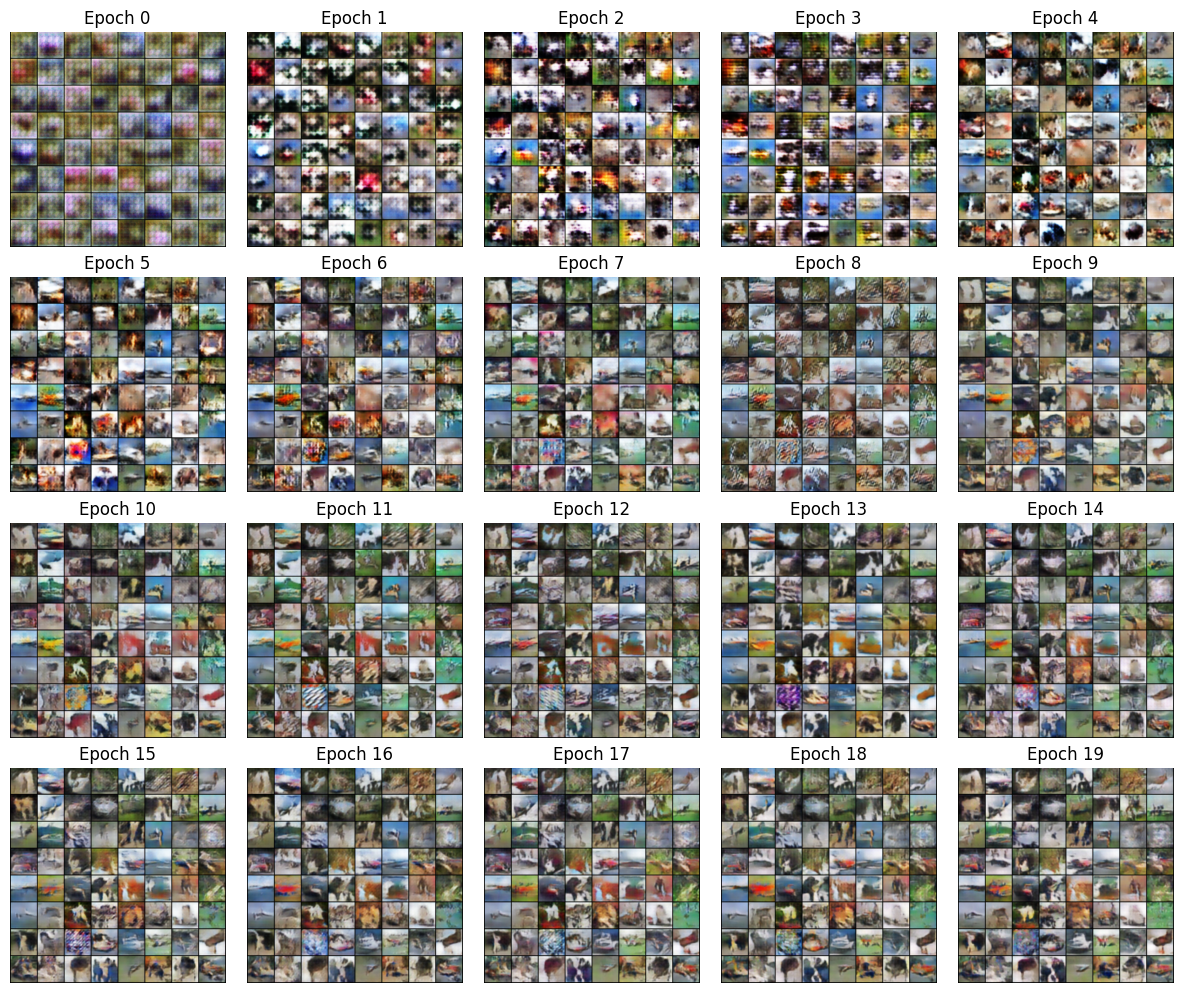

In [12]:
num_rows = 4
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
for epoch in range(num_epochs):
    img_path = 'fake_samples_%03d.png' % epoch
    img = mpimg.imread(img_path)
    row = epoch // num_cols
    col = epoch % num_cols
    axes[row, col].imshow(img)
    axes[row, col].set_title('Epoch {}'.format(epoch))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
